# Filmdatenbank mithilfe von SPARQL mit OpenData erweitern

### Disclaimer
Um den Code in diesem Notebook ausführen zu können, müssen vorher einige Packages installiert, importiert und eine Verbindung zur MongoDB aufgebaut werden. Dazu muss der nachstehende Code Block ausgeführt werden.

In [10]:
%pip install pymongo
%pip install SPARQL-Burger
%pip install requests
from SPARQLBurger.SPARQLQueryBuilder import *
import requests
import pandas as pd
import pymongo
from pprint import pprint
client = pymongo.MongoClient("mongodb://mongodb:27017")
db = client['moviedb']
collection = db['movie']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.3/493.3 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 2.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Aufgabe

### 1.1 Beschreibung
Eine vorgegebenen Filmdatenbank für die MongoDB soll mit OpenData erweitert werden. Als Datenbasis wird [Wikidata](https://wikidata.org/) genutzt, 
welche einer der größten offenen und kollaborativ erstellten Wissensdatenbanken der **Welt** ist. Die Filmdatenbank soll mit ausgewählten Informationen ergänzt werden und die neuen Daten dargestellt werden. Schlussendlich sollen neuen Abfragemöglichkeiten gezeigt werden, die sich aufgrund der neuen Daten ergeben.

### 1.2 Beispielhafter Datensatz
```json
{
  "_id": {
    "$oid": "646787ea309412c96f14b0c4"
  },
  "index": 0,
  "adult": "False",
  "belongs_to_collection": "{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",
  "budget": "30000000",
  "genres": "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",
  "homepage": "http://toystory.disney.com/toy-story",
  "id": "862",
  "imdb_id": "tt0114709",
  "original_language": "en",
  "original_title": "Toy Story",
  "overview": "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
  "popularity": 21.946943,
  "poster_path": "/rhIRbceoE9lR4veEXuwCC2wARtG.jpg",
  "production_companies": "[{'name': 'Pixar Animation Studios', 'id': 3}]",
  "production_countries": "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
  "release_date": "1995-10-30",
  "revenue": 373554033,
  "runtime": 81,
  "spoken_languages": "[{'iso_639_1': 'en', 'name': 'English'}]",
  "status": "Released",
  "tagline": {
    "$numberDouble": "NaN"
  },
  "title": "Toy Story",
  "video": false,
  "vote_average": 7.7,
  "vote_count": 5415,
}
```

### 1.3 Umsetzung

#### 1.3.1 Erweitern der Daten mithilfe von SPARQL

Um die gegebenen Filme mit Daten zu erweitern, müssen diese über eine Eigenschaft eindeutig identifiziert werden können. Jeder der Filme hat die Eigenschaft `imdb_id`. 

[IMDb (Internet Movie Database)](https://www.imdb.com/) ist eine amerikantische Datenbank für Filme, Serien und Spiele.

Wikidata besitzt einen Eintrag, in der die `imdb_id` (P345) als Eigenschaft beschrieben wird (https://www.wikidata.org/wiki/Property:P345). Entsprechend kann bei einer SPARQL Abfrage diese Eigenschaft genutzt werden, um den Film in der Wikidata Datenbank zu finden.

In der nachfolgenden Tabelle sind die neuen Daten aufgelistet, mit denen die vorhanden Filme erweitert wurden. Wie bei der IMDb ID hat jede Eigenschaft eine eigene Property ID, mit der diese eindeutig identifiziert werden kann.

| Name             | Property | URI                                          |
|------------------|----------|----------------------------------------------|
| Director         | P57      | https://www.wikidata.org/wiki/Property:P57   |
| Cast member      | P161     | https://www.wikidata.org/wiki/Property:P161  |
| Voice actor      | P725     | https://www.wikidata.org/wiki/Property:P725  |
| Producer         | P162     | https://www.wikidata.org/wiki/Property:P162  |
| Composer         | P86      | https://www.wikidata.org/wiki/Property:P86   |
| Main subject     | P921     | https://www.wikidata.org/wiki/Property:P921  |
| Follows          | P155     | https://www.wikidata.org/wiki/Property:P155  |
| Followed by      | P156     | https://www.wikidata.org/wiki/Property:P156  |
| Publication date | P577     | https://www.wikidata.org/wiki/Property:P577  |
| Cost             | P2130    | https://www.wikidata.org/wiki/Property:P2130 |

##### Abfrage in SPARQL
Die Daten werden über SPARQL von Wikidata abgefragt. Eine beispielhafte Abfrage für einen Film ist nachfolgend zu sehen.
```SQL
SELECT DISTINCT ?film ?filmLabel ?id ?director ?directorLabel ?castMember ?castMemberLabel ?voiceActor ?voiceActorLabel ?producer ?producerLabel ?composer ?composerLabel ?mainSubject ?mainSubjectLabel ?follows ?followsLabel ?followedBy ?followedByLabel ?publicationDate ?cost
WHERE {
   ?film wdt:P345 ?id . 
   SERVICE wikibase:label { bd:serviceParam wikibase:language 'en'. } . 
   OPTIONAL {
      ?film wdt:P57 ?director . 
   }
   OPTIONAL {
      ?film wdt:P161 ?castMember . 
   }
   OPTIONAL {
      ?film wdt:P725 ?voiceActor . 
   }
   OPTIONAL {
      ?film wdt:P162 ?producer . 
   }
   OPTIONAL {
      ?film wdt:P86 ?composer . 
   }
   OPTIONAL {
      ?film wdt:P921 ?mainSubject . 
   }
   OPTIONAL {
      ?film wdt:P155 ?follows . 
   }
   OPTIONAL {
      ?film wdt:P156 ?followedBy . 
   }
   OPTIONAL {
      ?film wdt:P577 ?publicationDate . 
   }
   OPTIONAL {
      ?film wdt:P2130 ?cost . 
   }
   FILTER (?id="tt0114709")
}
```

Beispielhafter Aufruf mithilfe des [Wikidata Query Service](https://query.wikidata.org/#SELECT%20DISTINCT%20%3Ffilm%20%3FfilmLabel%20%3Fid%20%3Fdirector%20%3FdirectorLabel%20%3FcastMember%20%3FcastMemberLabel%20%3FvoiceActor%20%3FvoiceActorLabel%20%3Fproducer%20%3FproducerLabel%20%3Fcomposer%20%3FcomposerLabel%20%3FmainSubject%20%3FmainSubjectLabel%20%3Ffollows%20%3FfollowsLabel%20%3FfollowedBy%20%3FfollowedByLabel%20%3FpublicationDate%20%3Fcost%0AWHERE%20%7B%0A%20%20%20%3Ffilm%20wdt%3AP345%20%3Fid%20.%20%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%27en%27.%20%7D%20.%20%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP57%20%3Fdirector%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP161%20%3FcastMember%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP725%20%3FvoiceActor%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP162%20%3Fproducer%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP86%20%3Fcomposer%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP921%20%3FmainSubject%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP155%20%3Ffollows%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP156%20%3FfollowedBy%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP577%20%3FpublicationDate%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP2130%20%3Fcost%20.%20%0A%20%20%20%7D%0A%20%20%20FILTER%20%28%3Fid%3D%22tt0114709%22%29%0A%7D%0A).

Wir haben den SPARQL Wrapper [SPARQLBurger](https://pmitzias.com/SPARQLBurger/) genutzt, mit denen SPARQL abfragen Objektorientiert erstellt werden können.

In [ ]:
%%time
select = ["?film", "?filmLabel", "?id", "?director", "?directorLabel", "?castMember", "?castMemberLabel", "?voiceActor",
          "?voiceActorLabel", "?producer", "?producerLabel", "?composer", "?composerLabel", "?mainSubject",
          "?mainSubjectLabel", "?follows", "?followsLabel", "?followedBy", "?followedByLabel", "?publicationDate",
          "?cost"]
select_query = SPARQLSelectQuery(distinct=True)
# SELECT
select_query.add_variables(select)
# Create a graph pattern
pattern = SPARQLGraphPattern()

# WHERE
pattern.add_triples(
    triples=[
        Triple(subject="?film", predicate="wdt:P345", object="?id"),
        Triple(subject="SERVICE", predicate="wikibase:label", object="{ bd:serviceParam wikibase:language 'en'. }")
    ]
)

# Filter
pattern.add_filter(filter=Filter(expression="?id='tt0114709'"))

for option in [
    {'predicate': "wdt:P57", 'object': "?director"},
    {'predicate': "wdt:P161", 'object': "?castMember"},
    {'predicate': "wdt:P725", 'object': "?voiceActor"},
    {'predicate': "wdt:P162", 'object': "?producer"},
    {'predicate': "wdt:P86", 'object': "?composer"},
    {'predicate': "wdt:P921", 'object': "?mainSubject"},
    {'predicate': "wdt:P155", 'object': "?follows"},
    {'predicate': "wdt:P156", 'object': "?followedBy"},
    {'predicate': "wdt:P577", 'object': "?publicationDate"},
    {'predicate': "wdt:P2130", 'object': "?cost"}]:
    # Create an optional graph pattern
    optionalPattern = SPARQLGraphPattern(optional=True)
    # OPTIONAL
    optionalPattern.add_triples(
        triples=[Triple(subject="?film", predicate=option['predicate'], object=option['object'])])

    # Merge both patterns into one
    pattern.add_nested_graph_pattern(optionalPattern)

select_query.set_where_pattern(pattern)
print(select_query.get_text())
r = requests.get('https://query.wikidata.org/sparql', params={'query': select_query.get_text()},
                    headers={'accept': 'application/sparql-results+json',
                            'User-Agent': 'HSD_DAW_BOT/1.0 (https://github.com/Sin-Yone/movie-db-sparql) python-requests'})
results = r.json()['results']['bindings']
print(results[0])

##### Problem
Wie man sieht wird der Film gefunden, allerdings ist die Ladezeit lange. Für ledeglich **einen** Film liegt die Abfragezeit dabei zwischen **10 und 20 Sekunden**. Der zur Verfügung gestellte Datensatz hat insgesamt 45466 Filme. Würde es für jeden Film 15 Sekunden dauern, wären dies circa **190 Stunden** oder **8 Tage**. Das ist sehr lange, weswegen die Zeit umbedingt verkürzt werden sollte.

##### Verbesserung der Abfrage
Die erstellte Abfrage kann verbessert werden, indem pro Anfrage mehrere Filme geladen werden, anstatt eine Anfrage für jeden Film. Die Anzahl wie viele Filme aufeinmal geladen werden können ist unterschiedlich. Beim Testen haben die Werte zwischen 50-100 pro Anfrage gut funktioniert. Alles über 200 führt zu einem Error da, der Anfrage-Header dann zu groß ist. Zur Darstellung werden folgend nur 25 Filme geladen, was als Beispiel allerdings ausreichend sein sollte.

Der Code von oben bleibt fast identisch. Allerdings wird der Filter angepasst, sodass die ID nicht gleich einer anderen ID ist, sondern mindestens eine der IDs in einem Array entspricht (IN Operator). 

Die verbesserte Abfrage sieht in SPARQL nun folgendermaßen aus:
```SQL
SELECT DISTINCT ?film ?filmLabel ?id ?director ?directorLabel ?castMember ?castMemberLabel ?voiceActor ?voiceActorLabel ?producer ?producerLabel ?composer ?composerLabel ?mainSubject ?mainSubjectLabel ?follows ?followsLabel ?followedBy ?followedByLabel ?publicationDate ?cost
WHERE {
   ?film wdt:P345 ?id . 
   SERVICE wikibase:label { bd:serviceParam wikibase:language 'en'. } . 
   OPTIONAL {
      ?film wdt:P57 ?director . 
   }
   OPTIONAL {
      ?film wdt:P161 ?castMember . 
   }
   OPTIONAL {
      ?film wdt:P725 ?voiceActor . 
   }
   OPTIONAL {
      ?film wdt:P162 ?producer . 
   }
   OPTIONAL {
      ?film wdt:P86 ?composer . 
   }
   OPTIONAL {
      ?film wdt:P921 ?mainSubject . 
   }
   OPTIONAL {
      ?film wdt:P155 ?follows . 
   }
   OPTIONAL {
      ?film wdt:P156 ?followedBy . 
   }
   OPTIONAL {
      ?film wdt:P577 ?publicationDate . 
   }
   OPTIONAL {
      ?film wdt:P2130 ?cost . 
   }
   FILTER (?id IN("tt0114709", "tt0113497", "tt0113228", "tt0114885", "tt0113041", "tt0113277", "tt0114319", "tt0112302", "tt0114576", "tt0113189", "tt0112346", "tt0112896", "tt0112453", "tt0113987", "tt0112760", "tt0112641", "tt0114388", "tt0113101", "tt0112281", "tt0113845", "tt0113161", "tt0112722", "tt0112401", "tt0114168", "tt0113627"))
}
```

Beispielhafter Aufruf mithilfe des [Wikidata Query Service](https://query.wikidata.org/#SELECT%20DISTINCT%20%3Ffilm%20%3FfilmLabel%20%3Fid%20%3Fdirector%20%3FdirectorLabel%20%3FcastMember%20%3FcastMemberLabel%20%3FvoiceActor%20%3FvoiceActorLabel%20%3Fproducer%20%3FproducerLabel%20%3Fcomposer%20%3FcomposerLabel%20%3FmainSubject%20%3FmainSubjectLabel%20%3Ffollows%20%3FfollowsLabel%20%3FfollowedBy%20%3FfollowedByLabel%20%3FpublicationDate%20%3Fcost%0AWHERE%20%7B%0A%20%20%20%3Ffilm%20wdt%3AP345%20%3Fid%20.%20%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%27en%27.%20%7D%20.%20%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP57%20%3Fdirector%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP161%20%3FcastMember%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP725%20%3FvoiceActor%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP162%20%3Fproducer%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP86%20%3Fcomposer%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP921%20%3FmainSubject%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP155%20%3Ffollows%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP156%20%3FfollowedBy%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP577%20%3FpublicationDate%20.%20%0A%20%20%20%7D%0A%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%20%3Ffilm%20wdt%3AP2130%20%3Fcost%20.%20%0A%20%20%20%7D%0A%20%20%20FILTER%20%28%3Fid%20IN%28%22tt0114709%22%2C%20%22tt0113497%22%2C%20%22tt0113228%22%2C%20%22tt0114885%22%2C%20%22tt0113041%22%2C%20%22tt0113277%22%2C%20%22tt0114319%22%2C%20%22tt0112302%22%2C%20%22tt0114576%22%2C%20%22tt0113189%22%2C%20%22tt0112346%22%2C%20%22tt0112896%22%2C%20%22tt0112453%22%2C%20%22tt0113987%22%2C%20%22tt0112760%22%2C%20%22tt0112641%22%2C%20%22tt0114388%22%2C%20%22tt0113101%22%2C%20%22tt0112281%22%2C%20%22tt0113845%22%2C%20%22tt0113161%22%2C%20%22tt0112722%22%2C%20%22tt0112401%22%2C%20%22tt0114168%22%2C%20%22tt0113627%22%29%29%0A%7D).

Bei 25 Filmen dauert es circa 30 Sekunden. Das bedeutet pro Film ungefähr **1,2 Sekunden**. Umgerechnet auf die 45466 Filme wären dies nur noch circa **15 Stunden** bzw. **0.6 Tage**. Dadurch können deutlich mehr Daten in einer kürzeren Zeit geladen werden.

In [ ]:
%%time

ids = list(map(lambda doc: doc['imdb_id'], collection.find({},{"imdb_id": 1}).limit(25)))
# Create a graph pattern
pattern = SPARQLGraphPattern()

# WHERE
pattern.add_triples(
    triples=[
        Triple(subject="?film", predicate="wdt:P345", object="?id"),
        Triple(subject="SERVICE", predicate="wikibase:label", object="{ bd:serviceParam wikibase:language 'en'. }")
    ]
)
# Filter
pattern.add_filter(filter=Filter(expression="?id IN({0})".format(', '.join(f'"{_id}"' for _id in ids))))

for option in [
    {'predicate': "wdt:P57", 'object': "?director"},
    {'predicate': "wdt:P161", 'object': "?castMember"},
    {'predicate': "wdt:P725", 'object': "?voiceActor"},
    {'predicate': "wdt:P162", 'object': "?producer"},
    {'predicate': "wdt:P86", 'object': "?composer"},
    {'predicate': "wdt:P921", 'object': "?mainSubject"},
    {'predicate': "wdt:P155", 'object': "?follows"},
    {'predicate': "wdt:P156", 'object': "?followedBy"},
    {'predicate': "wdt:P577", 'object': "?publicationDate"},
    {'predicate': "wdt:P2130", 'object': "?cost"}]:
    # Create an optional graph pattern
    optionalPattern = SPARQLGraphPattern(optional=True)
    # OPTIONAL
    optionalPattern.add_triples(
        triples=[Triple(subject="?film", predicate=option['predicate'], object=option['object'])])

    # Merge both patterns into one
    pattern.add_nested_graph_pattern(optionalPattern)

select_query.set_where_pattern(pattern)
print(select_query.get_text())
r = requests.get('https://query.wikidata.org/sparql', params={'query': select_query.get_text()},
                    headers={'accept': 'application/sparql-results+json',
                            'User-Agent': 'HSD_DAW_BOT/1.0 (https://github.com/Sin-Yone/movie-db-sparql) python-requests'})
results = r.json()['results']['bindings']
print(results[0:10])

##### Speichern der neuen Daten
Die Daten werden als JSON von Wikidata zurückgegeben. In einem Array wird jeder Film als ein Objekt repräsentiert. Dadurch das ein Film für eine Eigenschaft mehrere Werte haben kann, ist ein Film mehrmals in dem Array enthalten. Beispielsweise hat ein Film mehrere Darsteller (Cast Member). Entsprechend sind die Daten nicht sortiert und müssen zunächst aufbereitet werden.

##### Filme sortieren
Zuerst werden die Filme sortiert. Das bedeutet durch alle Ergebnisse wird iteriert und anhand der ID (imdb_id) der jeweilige Film identifiziert. Es wird ein neues Objekt (Dictionary) erstellt, wo der Key die ID des Filmes ist. Als Value werden in einem Array die Objekte des gleichen Filmes eingetragen. Damit sind alle Daten zu einem Film gruppiert.

In [ ]:
sortedMovies = {}
for movieData in results:
    if not movieData: continue
    if movieData['id']['value'] not in sortedMovies:
        sortedMovies[movieData['id']['value']] = [movieData]
    else:
        sortedMovies[movieData['id']['value']].append(movieData)

##### Filmdaten zusammenfassen
Nach der Gruppierung der Filme müssen alle Daten zu einem Film in einem Objekt zusammengefasst werden, um diese in der Datenbank abzuspeichern. Dazu wird durch das Objekt iteriert, indem die Filme gruppiert wurden. Als Key kriegen wir die ID und als Value entsprechend ein Array mit allen Objekt zu einem Film. Veröffentlichkeitsdatum, Kosten, Vorgänger und Nachfolger können immer nur einen Wert haben, weswegen wir diese direkt aus dem ersten Eintrag Filmobjekt entnehmen können. Für alle anderen Werte muss jeweils durch jeden Film iteriert werden. Dabei wird geprüft ob der jeweilige Wert schon in dem neuen Objekt vorhanden ist. Falls nicht wird dieser angehangen.

##### Updaten der Filme
Wenn in einer Iteration alle Daten zu einem Film in dem neuen Objekt zusammengefasst wurden, können sie in der Datenbank abgespeichert werden. Dazu wird wieder die IMDb ID genutzt, um den Film in der Datenbank zu identifizieren. Die neuen Daten werden dann an die bisherigen angehangen.

In [ ]:
for movieId, movies in sortedMovies.items():
    # merge all movie data into one object
    newMovieData = {
        'director': [],
        'cast_member': [],
        'voice_actor': [],
        'producer': [],
        'composer': [],
        'main_subject': [],
        'publication_date': movies[0].get('publicationDate', {'value': ''})['value'],
        'cost': movies[0].get('cost', {'value': ''})['value'],
        'follows': movies[0].get('followsLabel', {'value': ''})['value'],
        'followed_by': movies[0].get('followedByLabel', {'value': ''})['value'],
    }

    for movie in movies:
        if movie.get('directorLabel') and movie['directorLabel']['value'] not in newMovieData['director']:
            newMovieData[
                'director'].append(movie['directorLabel']['value'])
        if movie.get('castMemberLabel') and movie['castMemberLabel']['value'] not in newMovieData['cast_member']:
            newMovieData[
                'cast_member'].append(movie['castMemberLabel']['value'])
        if movie.get('voiceActorLabel') and movie['voiceActorLabel']['value'] not in newMovieData['voice_actor']:
            newMovieData[
                'voice_actor'].append(movie['voiceActorLabel']['value'])
        if movie.get('producerLabel') and movie['producerLabel']['value'] not in newMovieData['producer']:
            newMovieData[
                'producer'].append(movie['producerLabel']['value'])
        if movie.get('composerLabel') and movie['composerLabel']['value'] not in newMovieData['composer']:
            newMovieData[
                'composer'].append(movie['composerLabel']['value'])
        if movie.get('mainSubjectLabel') and movie['mainSubjectLabel']['value'] not in newMovieData['main_subject']:
            newMovieData[
                'main_subject'].append(movie['mainSubjectLabel']['value'])
    
    # Update db with new data
    collection.update_many({'imdb_id': movieId}, {'$set': newMovieData})

#### 1.3.2 Ergebnisse
##### Beispielhafter Datensatz mit erweiterten Informationen
TODO Lukas: Grafik mit erweiterten Datensatz

##### Metriken
Von den ursprünglichen 45466 Filmen konnten **42528** erweitert werden. Das bedeutet 2938 Filme sind entweder nicht auf Wikidata vorhanden oder konnten nicht mit über die IMDb ID identifiziert werden. Insgesamt konnten ungefähr **94%** der Filme mit Open Data erweitert werden.

Nachstehend ist eine Tabelle in der aufgelistet wird, bei wie vielen der erweiterten Filme (42528) tatsächlich Werte (nicht leer) vorhanden sind. Die Daten sagen aber nicht konkret aus, ob Filmdaten fehlen. Zum Beispiel haben nicht alle Filme einen Vorgänger oder Nachfolger. Daher haben sie entsprechend auch keinen Wert. Ähnlich ist dies auch bei Synchronsprechern. Die Darsteller sprechen sich in der original Sprache natürlich selbst, weswegen dort keine Werte vorhanden sind. Umgekehrt gibt es bei Animationsfilmen keine Darsteller sondern nur Synchronsprecher. Daher kann mit diesen Daten nicht genau bestimmt werden, wie zuverlässlich Open Data ist.

| Eigenschaft      | Anzahl Filme | Prozent (gerundet) |
|------------------|--------------|--------------------|
| Director         | 41871        | 98%                |
| Cast member      | 36756        | 86%                |
| Voice actor      | 1742         | 4%                 |
| Producer         | 25099        | 59%                |
| Composer         | 28502        | 67%                |
| Main subject     | 8849         | 21%                |
| Follows          | 3971         | 9%                 |
| Followed by      | 4382         | 10%                |
| Publication date | 41317        | 97%                |
| Cost             | 3069         | 7%                 |

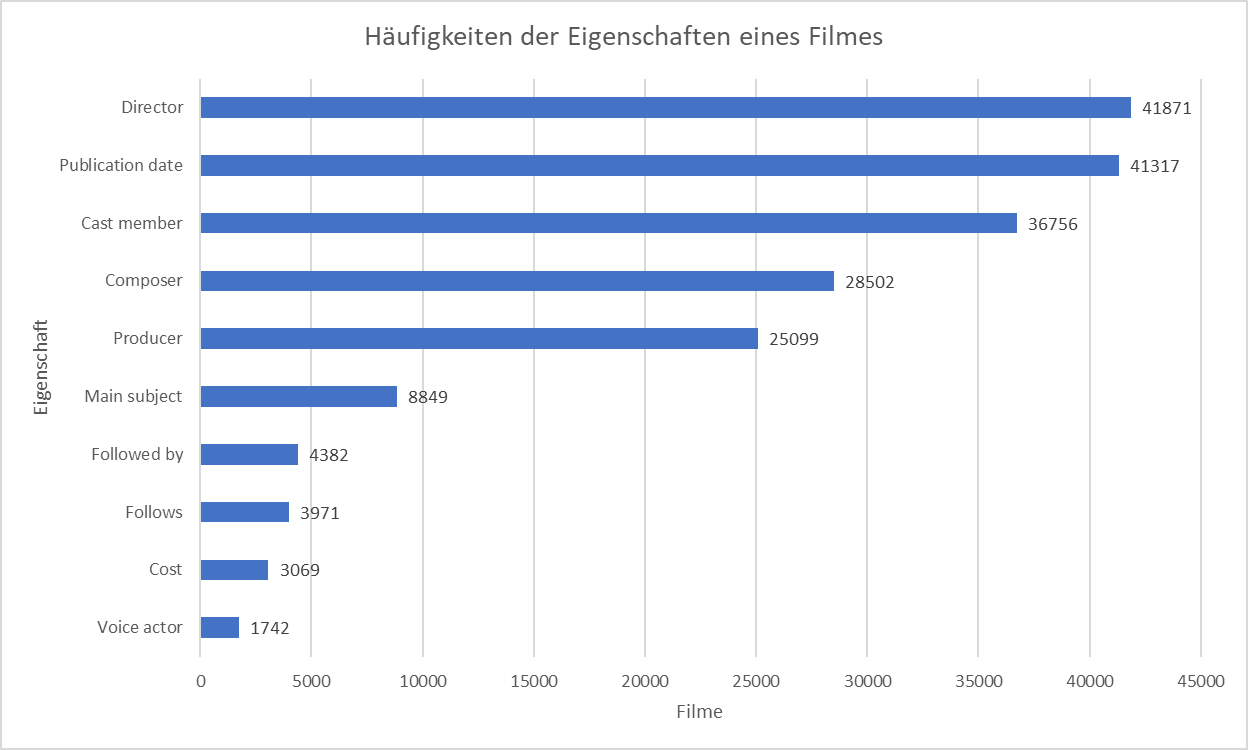

## 2. Abfragen mit der Datenbank

### 2.1 Beispielhafte Abfragen

#### Alle Filme mit Schauspieler X oder Y

##### In SPARQL

```SQL
SELECT DISTINCT ?film ?filmLabel ?id ?castMember ?castMemberLabel
WHERE {
  
  ?film wdt:P345 ?id ; 
        wdt:P161 ?castMember .
  
  FILTER(?castMember = wd:Q76478 -- Kirsten Dunst
            || ?castMember = wd:Q35332) -- Brad Pitt               
  SERVICE wikibase:label { bd:serviceParam wikibase:language 'en'. } . 
 
}
```

##### In Python mit PyMongo

In [11]:
movies = collection.find({'cast_member': { '$in': ['Kirsten Dunst', 'Brad Pitt']}})
for movie in movies:
    pprint(movie['title'])
    pprint(movie['cast_member'])
    pprint('-----------------------')

'Jumanji'
['Laura Bell Bundy',
 'Gillian Barber',
 'Gary Joseph Thorup',
 'James Handy',
 'Patricia Clarkson',
 'Malcolm Stewart',
 'Bradley Pierce',
 'Bebe Neuwirth',
 'Adam Hann-Byrd',
 'Bonnie Hunt',
 'Jonathan Hyde',
 'David Alan Grier',
 'Kirsten Dunst',
 'Robin Williams']
'-----------------------'


#### Alle Filme mit Thema X und Y

##### In SPARQL

```SQL
SELECT DISTINCT ?film ?filmLabel ?id ?mainSubject ?mainSubjectLabel
WHERE {
  
  ?film wdt:P345 ?id ; 
        wdt:P921 ?mainSubject .
  
  FILTER(?mainSubject = wd:Q179310 || ?castMember = wd:Q11660)                 
  SERVICE wikibase:label { bd:serviceParam wikibase:language 'en'. } . 
 
}    
```

##### In Python mit PyMongo

In [12]:
movies = collection.find({'main_subject': { '$in': ['computing', 'artificial intelligence']}})
for movie in movies:
    pprint(movie['title'])
    pprint(movie['main_subject'])
    pprint('-----------------------')

'GoldenEye'
['computing', 'organized crime', 'terrorism']
'-----------------------'


#### Alle Filme mit einem Vorgänger oder Nachfolger

##### In SPARQL

```SQL
SELECT DISTINCT ?film ?filmLabel ?id ?followedBy ?followedByLabel ?follows ?followsLabel
WHERE {
  
  ?film wdt:P345 ?id .
  
  OPTIONAL{?film wdt:P155 ?follows .}
  OPTIONAL{?film wdt:P156 ?followedBy .}
  
  FILTER( !isBlank(?follows) || !isBlank(?followedBy) ) 
  SERVICE wikibase:label { bd:serviceParam wikibase:language 'en'. } . 
    
}
```

##### In Python mit PyMongo

In [1]:
movies = collection.find({'$or': [ {'follows': {'$ne': ''}}, {'followed_by': {'$ne': ''}}]})
for movie in movies:
    if movie.get("follows", "") or movie.get("followed_by", ""):
        pprint(f'Titel: {movie.get("title", "")}')
        pprint(f'Vorgänger: {movie.get("follows", "")}')
        pprint(f'Nachfolger: {movie.get("followed_by", "")}')
        pprint('-----------------------')


NameError: name 'collection' is not defined

#### Alle Filme mit Kosten zwischen X und Y

##### In SparQL

```SQL
SELECT DISTINCT ?film ?filmLabel ?id ?cost
WHERE {
  
  ?film wdt:P345 ?id ;
        wdt:P2130 ?cost .
  
  FILTER( ( (?cost = 10000000) || (?cost > 10000000) ) && ( (?cost < 50000000) || (?cost = 50000000) ))
  SERVICE wikibase:label { bd:serviceParam wikibase:language 'en'. } . 
    
}
```

##### In Python mit PyMongo

In [14]:
movies = collection.find({'$and': [
     {'cost': {'$ne': ''}},
     {'$expr': {'$gte': [{'$toDouble': '$cost'}, 10000000]}},
     {'$expr': {'$lte': [{'$toDouble': '$cost'}, 50000000]}} 
     ]})
for movie in movies:
    pprint(f'Titel: {movie.get("title", "")} Kosten: {movie.get("cost", "")}')

'Titel: Toy Story Kosten: 30000000'
'Titel: Nixon Kosten: 44000000'
'Titel: Casino Kosten: 50000000'


### 2.2 Eure Abfragen

In [ ]:
movies = collection.find({})
for movie in movies:
    pprint(movie)